# Αναγνώριση Προτύπων - Μηχανική Μάθηση 3η Εργασία
## Στειροπούλου Ευαγγελία 
### 1115201800186

# FeedForward Neural Network

In [84]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install numpy
!pip install -U scikit-learn

import os
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
# from google.colab import drive
# drive.mount('/content/gdrive')

## Load mfccs Data 

In [85]:
path = os.getcwd()
print(path)

#path = '/content/gdrive/My Drive/Project3'

#create the paths for the data
training_data_path = path + '/data/music_genre_data_di/train/mfccs'
test_data_path = path + '/data/music_genre_data_di/test/mfccs'
validation_data_path = path + '/data/music_genre_data_di/val/mfccs'

X_train = np.load(training_data_path + '/X.npy')
y_train = np.load(training_data_path + '/labels.npy')
X_val   = np.load(validation_data_path + '/X.npy')
y_val   = np.load(validation_data_path + '/labels.npy')
X_test  = np.load(test_data_path + '/X.npy')
y_test  = np.load(test_data_path + '/labels.npy')

# Μετατροπή των labels σε ακέραιους αριθμούς (0, 1, 2, 3)
classes = np.unique(y_train)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

y_train = np.array([class_to_idx[label] for label in y_train])
y_val = np.array([class_to_idx[label] for label in y_val])
y_test = np.array([class_to_idx[label] for label in y_test])

# Δημιουργία των Tensor αντικειμένων από τα numpy arrays
train_dataset = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Εμφάνιση των διαστάσεων των Tensor
print(train_dataset.tensors[0].shape)
print(train_dataset.tensors[1].shape)
print(val_dataset.tensors[0].shape)
print(val_dataset.tensors[1].shape)
print(test_dataset.tensors[0].shape)
print(test_dataset.tensors[1].shape)


/home/eva/Documents/machine_learning/Project3
torch.Size([3200, 26])
torch.Size([3200])
torch.Size([800, 26])
torch.Size([800])
torch.Size([1376, 26])
torch.Size([1376])


## Build Neural Network

In [86]:
# # if we want to utilize the GPU (if available), we need to assign the model to the correct device
# if torch.cuda.is_available():
#   device="cuda"
# else:
#     device="cpu"

# print ("device=",device)

class FullyConnectedNeuralNetwork(nn.Module): ##NeuralNetwork iS A subclass of nn.module
    def __init__(self):
        super(FullyConnectedNeuralNetwork, self).__init__() ## call the constructor of super
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26 , 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = "cpu"
model = FullyConnectedNeuralNetwork().to(device)
print(model)

# X = torch.rand(1, 26, device = device)  ##dummy data στην  GPU

# # this call uses the forward function of the model along with some background operations.
# # Notice that we do not explicitly call forward. This is handled by PyTorch.
# log = model(X)

FullyConnectedNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


## Set Neural Network training function

In [87]:
def train_network(model, optimizer, dataloader, loss_function, num_epochs):
    size = len(dataloader.dataset)
    print("size = ", size)

    for epoch in range(num_epochs):
        loss = 0.0
        print("Epoch: ", epoch+1)
        for batch_idx, (data, targets) in enumerate(dataloader):
            #print("batch_idx = ", batch_idx)
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = loss_function(outputs, targets)
            
            # Clear the gradients and compute new gradients (backward pass)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # Update the weights

            if batch_idx % 64 == 0:
                loss, current = loss.item(), batch_idx * len(data)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    print('Training finished.')
    return model

## Set evaluation function

In [88]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate_model(model, dataloader, loss_function):
    model.eval()  # Put the model in evaluation mode
    device = next(model.parameters()).device

    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()

            all_predictions.extend(predictions.argmax(1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().detach().numpy())


    avg_loss = total_loss / len(dataloader)

    # Calculate F1 score, accuracy, and confusion matrix
    f1_score_macro = f1_score(all_targets, all_predictions, average='macro')
    accuracy = accuracy_score(all_targets, all_predictions)
    confusion_mat = confusion_matrix(all_targets, all_predictions)

    return avg_loss, f1_score_macro, accuracy, confusion_mat

## Train Neural Network

In [89]:
import torch.optim as optim
# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model
train_network(model, optimizer, train_dataloader, loss_function, num_epochs)

# Evaluate the trained model
avg_loss, f1_score_macro, accuracy, confusion_mat = evaluate_model(model, test_dataloader, loss_function)

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"F1 Score (Macro): {f1_score_macro}")
print(f"Accuracy: {accuracy*100} %")
print("Confusion Matrix:")
print(confusion_mat)
print(device)

# Return the trained model
trained_model = model

size =  3200
Epoch:  1
loss: 1.686768  [    0/ 3200]
loss: 1.367808  [ 1600/ 3200]
Epoch:  2
loss: 1.380132  [    0/ 3200]
loss: 1.376216  [ 1600/ 3200]
Epoch:  3
loss: 1.375163  [    0/ 3200]
loss: 1.363982  [ 1600/ 3200]
Epoch:  4
loss: 1.349799  [    0/ 3200]
loss: 1.384750  [ 1600/ 3200]
Epoch:  5
loss: 1.342178  [    0/ 3200]
loss: 1.345051  [ 1600/ 3200]
Epoch:  6
loss: 1.386654  [    0/ 3200]
loss: 1.348551  [ 1600/ 3200]
Epoch:  7
loss: 1.333812  [    0/ 3200]
loss: 1.346172  [ 1600/ 3200]
Epoch:  8
loss: 1.352916  [    0/ 3200]
loss: 1.295781  [ 1600/ 3200]
Epoch:  9
loss: 1.371296  [    0/ 3200]
loss: 1.353251  [ 1600/ 3200]
Epoch:  10
loss: 1.342784  [    0/ 3200]
loss: 1.338672  [ 1600/ 3200]
Epoch:  11
loss: 1.342086  [    0/ 3200]
loss: 1.291246  [ 1600/ 3200]
Epoch:  12
loss: 1.288844  [    0/ 3200]
loss: 1.354313  [ 1600/ 3200]
Epoch:  13
loss: 1.195256  [    0/ 3200]
loss: 1.301192  [ 1600/ 3200]
Epoch:  14
loss: 1.349678  [    0/ 3200]
loss: 1.229513  [ 1600/ 3200]
Ep

## Train Network with GPU

In [90]:
import torch.optim as optim
# if we want to utilize the GPU (if available), we need to assign the model to the correct device

if torch.cuda.is_available():
    device="cuda"
    print("GPU available")
else:
    device="cpu"

print ("device=",device)
model = FullyConnectedNeuralNetwork().to(device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model
train_network(model, optimizer, train_dataloader, loss_function, num_epochs)

# Evaluate the trained model
avg_loss, f1_score_macro, accuracy, confusion_mat = evaluate_model(model, test_dataloader, loss_function)

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"F1 Score (Macro): {f1_score_macro}")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_mat)

# Return the trained model
trained_model = model

device= cpu
size =  3200
Epoch:  1
loss: 1.422322  [    0/ 3200]
loss: 1.422875  [ 1600/ 3200]
Epoch:  2
loss: 1.405496  [    0/ 3200]
loss: 1.381212  [ 1600/ 3200]
Epoch:  3
loss: 1.386479  [    0/ 3200]
loss: 1.351577  [ 1600/ 3200]
Epoch:  4
loss: 1.361685  [    0/ 3200]
loss: 1.333834  [ 1600/ 3200]
Epoch:  5
loss: 1.362240  [    0/ 3200]
loss: 1.343281  [ 1600/ 3200]
Epoch:  6
loss: 1.349986  [    0/ 3200]
loss: 1.370254  [ 1600/ 3200]
Epoch:  7
loss: 1.329741  [    0/ 3200]
loss: 1.350750  [ 1600/ 3200]
Epoch:  8
loss: 1.377726  [    0/ 3200]
loss: 1.321083  [ 1600/ 3200]
Epoch:  9
loss: 1.315151  [    0/ 3200]
loss: 1.316003  [ 1600/ 3200]
Epoch:  10
loss: 1.309912  [    0/ 3200]
loss: 1.305246  [ 1600/ 3200]
Epoch:  11
loss: 1.296034  [    0/ 3200]
loss: 1.281989  [ 1600/ 3200]
Epoch:  12
loss: 1.268032  [    0/ 3200]
loss: 1.330161  [ 1600/ 3200]
Epoch:  13
loss: 1.299872  [    0/ 3200]
loss: 1.264784  [ 1600/ 3200]
Epoch:  14
loss: 1.309052  [    0/ 3200]
loss: 1.205132  [ 16

## Choose model

In [91]:
def train_and_evaluate(model, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, num_epochs):
    best_model = None
    best_f1 = 0.0

    # Training loop
    for epoch in range(num_epochs):
        print(f"EPOCH: {epoch+1}")
        # Train the model
        train_network(model, optimizer, train_dataloader, loss_function, 1)

        # Evaluate the model on the validation set
        val_loss, val_f1, val_accuracy, val_confusion_mat = evaluate_model(model, val_dataloader, loss_function)

        print(f"Epoch: {epoch+1}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation F1: {val_f1:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print("Validation Confusion Matrix:")
        print(val_confusion_mat)

        # Save the model with the best F1 score on the validation set
        if val_f1 > best_f1:
            best_model = model
            best_f1 = val_f1

    # Evaluate the best model on the test set
    test_loss, test_f1, test_accuracy, test_confusion_mat = evaluate_model(best_model, test_dataloader, loss_function)

    print("Best Model Performance on Test Set:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Test Confusion Matrix:")
    print(test_confusion_mat)

    return best_model, test_loss, test_f1, test_accuracy, test_confusion_mat

In [92]:
best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs
)

size =  3200
Epoch:  1
loss: 0.803571  [    0/ 3200]
loss: 1.076104  [ 1600/ 3200]
Training finished.
Epoch: 1
Validation Loss: 0.9087
Validation F1: 0.6624
Validation Accuracy: 0.6763
Validation Confusion Matrix:
[[ 65  34  80  21]
 [ 16 175   4   5]
 [ 26   2 160  12]
 [ 27  14  18 141]]
size =  3200
Epoch:  1
loss: 1.180392  [    0/ 3200]
loss: 0.966003  [ 1600/ 3200]
Training finished.
Epoch: 2
Validation Loss: 0.9181
Validation F1: 0.6087
Validation Accuracy: 0.6338
Validation Confusion Matrix:
[[ 40  26 109  25]
 [ 34 141   6  19]
 [ 10   1 179  10]
 [ 17   8  28 147]]
size =  3200
Epoch:  1
loss: 1.131207  [    0/ 3200]
loss: 0.725396  [ 1600/ 3200]
Training finished.
Epoch: 3
Validation Loss: 0.8901
Validation F1: 0.6569
Validation Accuracy: 0.6750
Validation Confusion Matrix:
[[ 65  49  50  36]
 [  7 179   3  11]
 [ 36   4 136  24]
 [ 15  16   9 160]]
size =  3200
Epoch:  1
loss: 1.052137  [    0/ 3200]
loss: 1.015323  [ 1600/ 3200]
Training finished.
Epoch: 4
Validation Loss:

# Convolutional Neural Network

## Load spectrograms data

In [93]:
path = os.getcwd()
print(path)

#path = '/content/gdrive/My Drive/Project3'

#create the paths for the data
training_data_path = path + '/data/music_genre_data_di/train/melgrams'
test_data_path = path + '/data/music_genre_data_di/test/melgrams'
validation_data_path = path + '/data/music_genre_data_di/val/melgrams'

X_train = np.load(training_data_path + '/X.npy')
y_train = np.load(training_data_path + '/labels.npy')
X_val   = np.load(validation_data_path + '/X.npy')
y_val   = np.load(validation_data_path + '/labels.npy')
X_test  = np.load(test_data_path + '/X.npy')
y_test  = np.load(test_data_path + '/labels.npy')

classes = np.unique(y_train)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

y_train = np.array([class_to_idx[label] for label in y_train])
y_val = np.array([class_to_idx[label] for label in y_val])
y_test = np.array([class_to_idx[label] for label in y_test])

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Εμφάνιση των διαστάσεων των Tensor
print(train_dataset.tensors[0].shape)
print(train_dataset.tensors[1].shape)
print(val_dataset.tensors[0].shape)
print(val_dataset.tensors[1].shape)
print(test_dataset.tensors[0].shape)
print(test_dataset.tensors[1].shape)


/home/eva/Documents/machine_learning/Project3
torch.Size([3200, 21, 128])
torch.Size([3200])
torch.Size([800, 21, 128])
torch.Size([800])
torch.Size([1376, 21, 128])
torch.Size([1376])


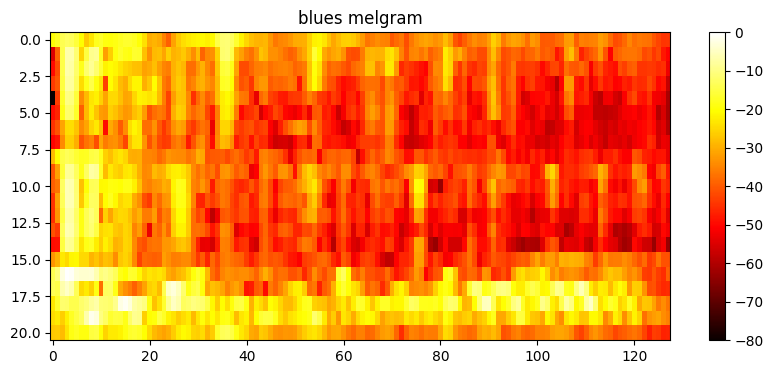

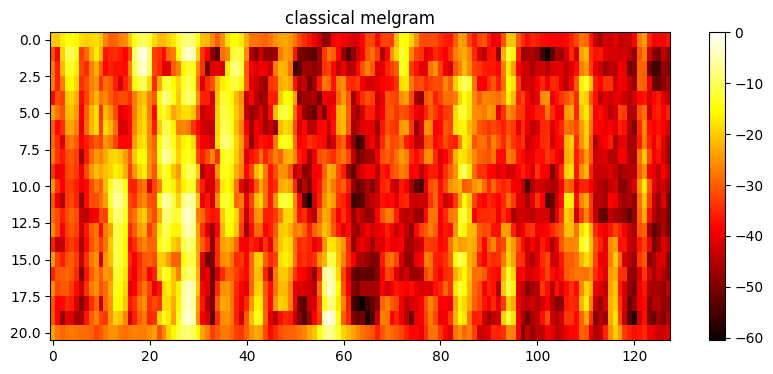

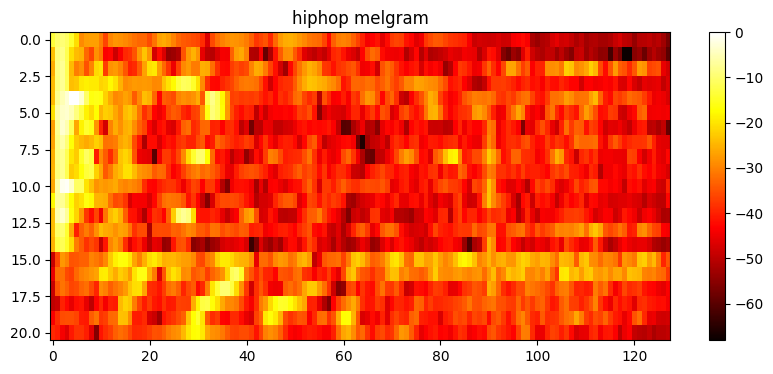

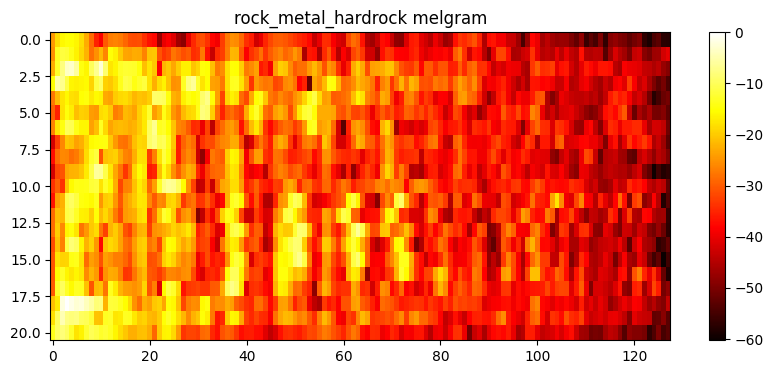

In [94]:
import random

def visualize_melgram(melgram, class_name):
    plt.figure(figsize=(10, 4))
    plt.imshow(melgram, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(class_name + ' melgram')
    plt.show()

# Function to plot a random melgram from each class
def plot_random_melgram_from_each_class(dataset, class_labels, class_names):
    classes = np.unique(class_labels)
    for class_label in classes:
        indices = np.where(class_labels == class_label)[0]
        # Select a random index
        random_index = random.choice(indices)
        melgram, label = dataset[random_index]
        class_name = class_names[class_label]  # Get the class name corresponding to the class label
        visualize_melgram(melgram, class_name)

# Retrieve the class names from the class_to_idx dictionary
class_names = [class_label for class_label, class_index in class_to_idx.items()]

# Plot a random melgram from each class in the training dataset
plot_random_melgram_from_each_class(train_dataset, y_train, class_names)


## Build Neural Network

In [95]:
#set a convolutional neural network with 5 kernels and 4 convolutional layers with sequential 1,16,32,64,128
#and the exit of the last layer to be inserted in a fully connected layer with 5 layers and neurons x(dimensions of the exit of the last convolutional layer), 1024,256,32, out_dim
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)

        self.flatten = nn.Flatten()

        # Fully connected stack 5*12*128 = 71680
        self.connected_stack = nn.Sequential(
            nn.Linear(71680, 1024), 
            nn.Linear(1024, 256), 
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def forward(self, x): 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.connected_stack(x)
        return logits

model = ConvolutionalNet().to(device)
print(model)

ConvolutionalNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (connected_stack): Sequential(
    (0): Linear(in_features=71680, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=4, bias=True)
  )
)


## Train Network

In [101]:
def train_network(model, optimizer, dataloader, loss_function, num_epochs, device):
    model.train()  # Put the model in training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        #print("Epoch:", epoch+1)
        for batch_idx, (data, targets) in enumerate(dataloader):
            data = data.to(device)
            data = data.unsqueeze(1)  # Add a channel dimension
            targets = targets.to(device)

            optimizer.zero_grad()  # Clear the gradients

            # Forward pass
            outputs = model(data)
            loss = loss_function(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()  # Update the weights

            running_loss += loss.item()

            if batch_idx % 64 == 99:  # Print the loss every 64 batches
                print(f"Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0

    print('Training finished.')

def evaluate_model(model, dataloader, loss_function, device):
    model.eval()  # Put the model in evaluation mode

    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            data = data.unsqueeze(1)  # Add a channel dimension
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()

            all_predictions.extend(predictions.argmax(1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().detach().numpy())

    avg_loss = total_loss / len(dataloader)

    # Calculate F1 score, accuracy, and confusion matrix
    f1_score_macro = f1_score(all_targets, all_predictions, average='macro')
    accuracy = accuracy_score(all_targets, all_predictions)
    confusion_mat = confusion_matrix(all_targets, all_predictions)

    return avg_loss, f1_score_macro, accuracy, confusion_mat


In [106]:
def train_and_evaluate(model, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, num_epochs):
    best_model = None
    best_f1 = 0.0
    best_epoch = 0

    # Training loop
    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        # Train the model
        train_network(model, optimizer, train_dataloader, loss_function, 1, device)

        # Evaluate the model on the validation set
        val_loss, val_f1, val_accuracy, val_confusion_mat = evaluate_model(model, val_dataloader, loss_function, device)

        print(f"Epoch: {epoch+1}")
        print(f"Validation Loss: {val_loss:.4f*100}%")
        print(f"Validation F1: {val_f1:.4f*100}%")
        print(f"Validation Accuracy: {val_accuracy:.4f*100}%")
        print("Validation Confusion Matrix:")
        print(val_confusion_mat)

        # Save the model with the best F1 score on the validation set
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch + 1

    # Evaluate the best model on the test set
    test_loss, test_f1, test_accuracy, test_confusion_mat = evaluate_model(best_model, test_dataloader, loss_function, device)

    print("Best Model Performance on Test Set:")
    print(f"Test Loss: {test_loss:.4f*100}%")
    print(f"Test F1: {test_f1:.4f*100}%")
    print(f"Test Accuracy: {test_accuracy:.4f*100}%")
    print("Test Confusion Matrix:")
    print(test_confusion_mat)

    #plot confusion matrix
    

    
    
    return best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat

In [98]:
# Hyperparameters and Network initialisation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet().to(device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model and find optimal model
best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)
print("\nBest F1 macro average score achieved after ", best_epoch, " epochs.")

Epoch: 1
Batch [100/200], Loss: nan
Batch [200/200], Loss: nan
Training finished.
Epoch: 1
Validation Loss: nan
Validation F1: 0.1000
Validation Accuracy: 0.2500
Validation Confusion Matrix:
[[200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]]
Epoch: 1
Batch [100/200], Loss: nan
Batch [200/200], Loss: nan
Training finished.
Epoch: 2
Validation Loss: nan
Validation F1: 0.1000
Validation Accuracy: 0.2500
Validation Confusion Matrix:
[[200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]]
Epoch: 1
Batch [100/200], Loss: nan
Batch [200/200], Loss: nan
Training finished.
Epoch: 3
Validation Loss: nan
Validation F1: 0.1000
Validation Accuracy: 0.2500
Validation Confusion Matrix:
[[200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]]
Epoch: 1
Batch [100/200], Loss: nan
Batch [200/200], Loss: nan
Training finished.
Epoch: 4
Validation Loss: nan
Validation F1: 0.1000
Validation Accuracy: 0.2500
Validation Confusion Matrix:
[[200

KeyboardInterrupt: 

From the results it is clear that the model is unable to train. The loss immediately goes to infinity so it means that the principal features cannot be extracted. This highlights the importance of Max pooling.

## Set padding to the Convolutional Network

In [103]:
#set convolutional network with padding to 2 and kernel size to 2
import torch.nn.functional as F

class ConvolutionalNet2(nn.Module):
    def __init__(self):
        super(ConvolutionalNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        self.flatten = nn.Flatten()
        self.connected_stack = nn.Sequential(
            nn.Linear(1024, 1024), 
            nn.Linear(1024, 256), 
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size=2)
        x = self.flatten(x)

        logits = self.connected_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet2().to(device)
print(model)


ConvolutionalNet2(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (connected_stack): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [105]:
# Hyperparameters and Network initialisation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet2().to(device)
print("device: ", device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model and find optimal model
best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)
print("\nBest F1 macro average score: " ,test_f1*100 ,"% achieved after ", best_epoch, " epochs.")


device:  cpu
Epoch:  1
Training finished.
Epoch: 1
Validation Loss: 1.3499
Validation F1: 0.2329
Validation Accuracy: 0.3212
Validation Confusion Matrix:
[[ 16   3 181   0]
 [ 69  44  87   0]
 [  3   0 197   0]
 [ 41   0 159   0]]
Epoch:  2
Training finished.
Epoch: 2
Validation Loss: 1.3402
Validation F1: 0.1529
Validation Accuracy: 0.2750
Validation Confusion Matrix:
[[  0 200   0   0]
 [  0 198   1   1]
 [  0 185  15   0]
 [  0 192   1   7]]
Epoch:  3
Training finished.
Epoch: 3
Validation Loss: 1.1842
Validation F1: 0.2943
Validation Accuracy: 0.4263
Validation Confusion Matrix:
[[  1 109  90   0]
 [  0 182  17   1]
 [  0  46 154   0]
 [  0  47 149   4]]
Epoch:  4
Training finished.
Epoch: 4
Validation Loss: 1.1759
Validation F1: 0.3302
Validation Accuracy: 0.4225
Validation Confusion Matrix:
[[ 34 143  23   0]
 [  0 197   2   1]
 [ 20  73 107   0]
 [ 50  72  78   0]]
Epoch:  5
Training finished.
Epoch: 5
Validation Loss: 1.0318
Validation F1: 0.5498
Validation Accuracy: 0.5613
Val

## Optimization Algorithms

In [108]:
#run all  the optimization algorithms of pytorch and compare the results
import torch.optim as optim

algorithms = [optim.Adadelta, optim.Adagrad, optim.Adam, 
              optim.AdamW, optim.SparseAdam, optim.Adamax, 
              optim.ASGD, optim.LBFGS, optim.NAdam, 
              optim.RAdam, optim.RMSprop, optim.Rprop, optim.SGD]
loss_function = nn.CrossEntropyLoss()
num_epochs = 30

#learning_rates = [0.2, 0.02, 0.002]

# Define a list of metrics to evaluate
metrics = ['accuracy', 'f1']

# Create an empty dictionary to store the results
results = {}

# Hyperparameters and Network initialisation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

for algorithm in  algorithms:
    model = ConvolutionalNet2().to(device)

    # Define the optimizer, learning rate, and loss function
    optimizer = algorithm(model.parameters(), lr=0.002)

    # Train the model and find optimal model
    best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
        model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)
    # Store the results in the dictionary
    results[algorithm] = {'accuracy': test_accuracy, 'f1': test_f1}

# Print the results in a table format
print("Optimizer\tAccuracy\tF1")
for optimizer_name, metrics_dict in results.items():
    print(f"{optimizer_name}\t{metrics_dict['accuracy']:.4f}\t\t{metrics_dict['f1']:.4f}")

# Find the optimizer with the best accuracy
best_accuracy_optimizer = max(results, key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_accuracy_optimizer]['accuracy']

# Find the optimizer with the best F1 score
best_f1_optimizer = max(results, key=lambda x: results[x]['f1'])
best_f1 = results[best_f1_optimizer]['f1']

# Print the best results
print("Best Accuracy:")
print(f"Optimizer: {best_accuracy_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")

print("\nBest F1 Score:")
print(f"Optimizer: {best_f1_optimizer}")
print(f"F1 Score: {best_f1:.4f}")

device:  cpu
Epoch:  1
